# 模型analysis

In [153]:
import glob
import os
import argparse
import random
import shutil
from tqdm import tqdm

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

import models
import metrics
from utils.data_util import upsample
from utils.train_util import AverageMeter, ProgressMeter

In [154]:
def load_data(data_dir, data_name, batch_size, tpye='gc'):
    class_names = os.listdir(os.path.join(data_dir, data_name))
    for dir_name in class_names:
        if os.path.isfile(os.path.join(data_dir, data_name, dir_name)):
            class_names.remove(dir_name)
    print('class_names', class_names)

    train_loader = []
    val_loader = []
    test_dataset = []
    graph_num = 0

    for i, class_name in enumerate(class_names):
        nodes_files = glob.glob(
            os.path.join(data_dir, data_name, class_name, f'*_nodes.csv'))
        edges_files = glob.glob(
            os.path.join(data_dir, data_name, class_name, f'*_edges.csv'))
        print(class_name + ' #graph:', len(nodes_files))

        dataset = []
        for node_files, edges_file in zip(sorted(nodes_files), sorted(edges_files)):
            x = load_nodes(node_files, 4)
            edge_index = load_edges(edges_file)
            assert len(x) >= edge_index.max(), "{}, {}, {}, {}".format(
                node_files, edges_file, len(x), edge_index.max())
            y = class_names.index(class_name)
            assert y < 2
            data = Data(x=x, edge_index=edge_index, y=y)

            graph_num += 1
            dataset.append(data)
        index = len(dataset) // 3
        test_dataset += dataset[index:index+16]

    test_loader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             shuffle=False)

    return train_loader, val_loader, test_loader


def load_nodes(nodes_dir, num_nodes_feature=4):
    nodes = pd.read_csv(nodes_dir, usecols=range(1, num_nodes_feature + 1))
    x = nodes.to_numpy(np.float32)
    x = torch.from_numpy(x).cuda()
    return x


def load_edges(edges_dir):
    edges = pd.read_csv(edges_dir)
    edges_from_index = edges['from_node'].to_numpy()
    edges_to_index = edges['to_node'].to_numpy()
    edge_index = np.array([edges_from_index, edges_to_index])
    edge_index = torch.from_numpy(edge_index).long().cuda()
    return edge_index


In [155]:
result_path = '/nfs4-p1/gj/DEFECT2022/results/'

model_name = 'GCN'

data_name = 'CrackForest'
in_channels = 4
n_class = 2
epochs = 200

seed = 100
batch_size = 32

# exp_name = model_name + '_gc_' + data_name
# model_dir = result_path + exp_name + '/models'
# data_dir = '/nfs4-p1/gj/DEFECT2022/data/old'
# log_dir = '/nfs4-p1/gj/DEFECT2022/runs/' + exp_name
# device_index = '1'

exp_name=model_name+'_gray_gc_'+data_name
model_dir=result_path+exp_name+'/models'
data_dir='/nfs4-p1/gj/DEFECT2022/data1'
log_dir='/nfs4-p1/gj/DEFECT2022/runs/'+exp_name
device_index='1'

In [156]:
def test(model, loader, criterion, device):
    loss_meter = AverageMeter('Loss', ':.4e')
    acc1_meter = AverageMeter('Acc@1', ':6.2f')
    progress = ProgressMeter(total=len(loader),
                             step=20,
                             prefix='Test',
                             meters=[loss_meter])
    class_acc = metrics.ClassAccuracy()
    auc_ap = metrics.AUC_AP()

    model.eval()
    for i, data in enumerate(loader):
        data = data.to(device)
        with torch.set_grad_enabled(False):
            outputs = model(data.x, data.edge_index, data.batch)
        return outputs, data


In [157]:
os.environ["CUDA_VISIBLE_DEVICES"] = device_index
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [158]:
train_loader, val_loader, test_loader = load_data(data_dir, data_name,
                                                  batch_size, 'gc')

model = torch.load(os.path.join(model_dir, 'model_ori.pth'))
model.to(device)

criterion = torch.nn.CrossEntropyLoss() 

class_names ['Normal', 'Anomalous']
Normal #graph: 1662
Anomalous #graph: 1170


In [166]:
model_dir

'/nfs4-p1/gj/DEFECT2022/results/GCN_gray_gc_CrackForest/models'

In [159]:
outputs, data = test(model, test_loader, criterion, device)

In [160]:
predict = torch.max(outputs, 1)[1]
predict

tensor([0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1,
        0, 1, 1, 0, 1, 1, 1, 0], device='cuda:0')

In [161]:
def draw(data):
    # data = data[data[:, 2]> 3]
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.set_xlim((10,0))
    ax.set_ylim((0, 10))
    ax.set_zlim((16,0))
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.scatter3D(data[:, 0], data[:, 1], data[:, 3], c=data[:, 3], cmap='Blues_r')


In [162]:
data.y

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')

In [163]:
index = np.nonzero(predict - data.y).view(-1)
index.cpu().numpy().tolist()

[1, 4, 5, 6, 7, 11, 14, 15, 16, 18, 19, 20, 24, 27, 31]

In [164]:
data.y[index.cpu().numpy().tolist()]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')

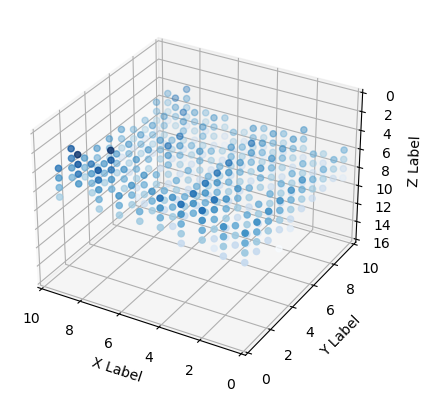

In [165]:
draw(data[11].x.cpu().numpy()) # wrong

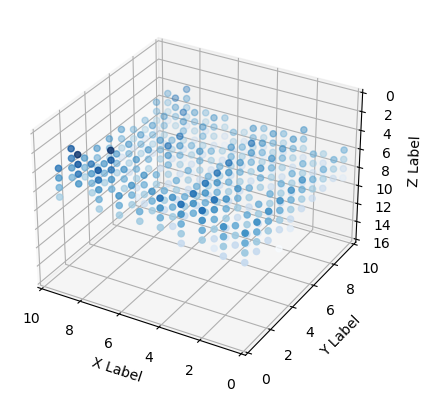

In [149]:
draw(data[11].x.cpu().numpy()) # wrong [1, 4, 5, 6, 7, 11, 14, 15, 16, 18, 19, 20, 24, 27, 31]

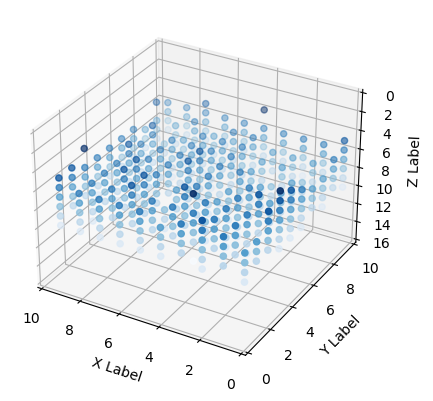

In [151]:
draw(data[30].x.cpu().numpy())# wrong [1, 4, 5, 6, 7, 11, 14, 15, 16, 18, 19, 20, 24, 27, 31]

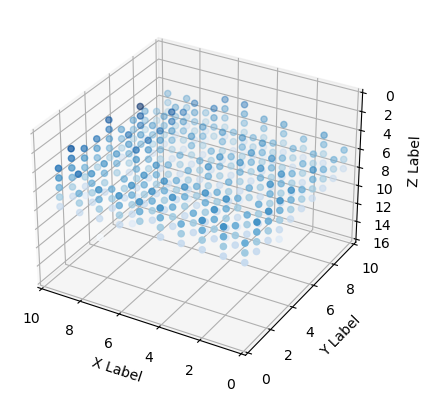

In [ ]:
draw(data[27].x.cpu().numpy()
     )  # wrong [1, 4, 5, 6, 7, 11, 14, 15, 16, 18, 19, 20, 24, 27, 31]


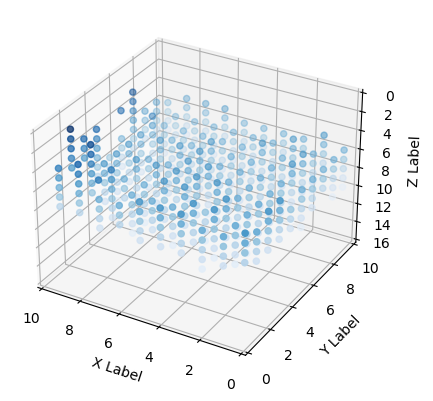

In [ ]:
draw(data[16].x.cpu().numpy()
     )  # wrong [1, 4, 5, 6, 7, 11, 14, 15, 16, 18, 19, 20, 24, 27, 31]


# 整体数据集归一化
min_c = 28
max_c = 245

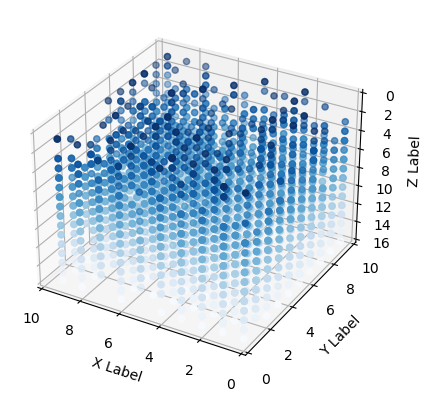

In [ ]:
draw(data[15].x.cpu().numpy())

## 没有过滤density

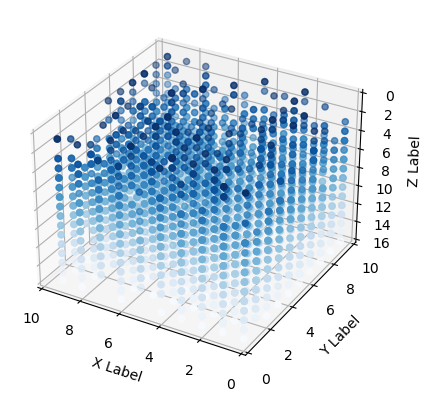

In [ ]:
draw(data[15].x.cpu().numpy())

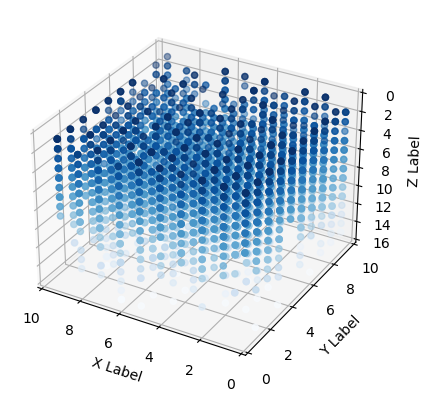

In [72]:
draw(data[0].x.cpu().numpy())

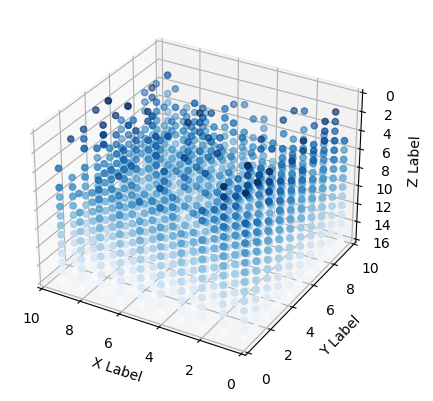

In [73]:
draw(data[3].x.cpu().numpy())

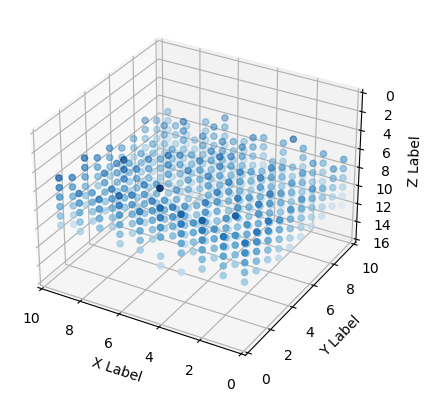

In [37]:
draw(data[6].x.cpu().numpy())

# 数据处理analysi

In [1]:
import glob
import cv2
import numpy as np

datasets_root = "/nfs4-p1/gj/datasets/AnomalyDetection"
class_names = ['Normal', 'Anomalous']

dataset_name = "CrackForest"
unit_size = 8
color_unit_size = 16

img_list = glob.glob(
    os.path.join(datasets_root, dataset_name, 'image', f'*.jpg'))

gray_max, gray_min = 0, 256
statics = np.zeros(256)

for i, image in enumerate(img_list):
    img = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2GRAY)
    uni, counts = np.unique(img, return_counts=True)
    for c, count in zip(uni, counts):
        statics[c] =i/ (i + 1)*statics[c] +count / (i + 1)
    gray_max = img.max() if gray_max < img.max() else gray_max
    gray_min = img.min() if gray_min > img.min() else gray_min

In [2]:
gray_min, gray_max

(1, 255)

In [3]:
np.nonzero(statics.astype(np.int64))


(array([ 28,  30,  31,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
         43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
         69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
         82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
         95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
        108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
        121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
        134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
        147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,
        160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172,
        173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185,
        186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198,
        199, 200, 201, 202, 203, 204, 205, 206, 207

In [77]:
whole = (statics * 500 / statics.sum()).astype(np.int64)
np.nonzero(whole)

(array([ 97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
        110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
        123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
        136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,
        149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161,
        162, 163]),)